<a href="https://colab.research.google.com/github/hyeonzz/ESAA_24-1_OB/blob/writing/0318%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

핸즈온 7장 앙상블 학습과 랜덤 포레스트(p.245-271)      


--------------------------------

## CHAPTER 7. 앙상블 학습과 랜덤 포레스트
- 앙상블 학습: 일련의 예측기(분류나 회귀 모델)로부터 예측을 수집해 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있음.
- 결정 트리의 앙상블: 랜덤 포레스트

### 7.1 투표 기반 분류기
- 직접 투표 분류기(hard voting)
> - 학습한 여러 개의 분류기의 예측을 모아서 가장 많이 선택된 클래스(결과값)를 예측하는 것.
> - 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다 정확도가 높은 경우가 많음.

! 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘함. 다양한 분류기를 얻는 한 가지 방법은 각기 다른 알고리즘으로 학습시키는 것인데 이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킴.

In [1]:
import numpy as np
import pandas as pd

In [2]:
#데이터 준비하기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=150, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90)

In [3]:
#투표 기반 분류기(VotingClassifier)
#hardvoting
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr',log_clf), ('rf', rnd_clf), ('svc',svm_clf)],voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [4]:
#각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred)) #흠,,,

LogisticRegression 0.8666666666666667
RandomForestClassifier 0.9333333333333333
SVC 0.9666666666666667
VotingClassifier 0.9666666666666667


In [5]:
#투표 기반 분류기(VotingClassifier)
#softvoting
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr',log_clf), ('rf', rnd_clf), ('svc',svm_clf)],voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())],
                 voting='soft')

### 7.2 배깅과 페이스팅
- 배깅: 같은 알고리즘을 사용하고 훈련 세트에서 중복을 허용하여 서브셋을 무작위로 구성하고 분류기를 각기 다르게 학습시키는 것
- 페이스팅: 중복을 허용하지 않고 배깅과 같은 방식으로 학습시키는 것.

#### 7.2.1 사이킷런의 배깅과 페이스팅
- BaggingClassifier: 배깅과 페이스팅을 위한 사이킷런 API

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
    #500개의 앙상블 훈련
    #100개의 샘플을 배깅 방식으로 선택
    #사이킷런이 훈련과 예측에 가용한 모든 CPU 코어 사용

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

!NOTE: BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면(즉, predict_proba() 함수가 있으면) 직접 투표 대신 자동으로 간접 투표 방식을 사용함.

앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 보통 더 잘 됨. 왜냐하면 앙상블은 비슷한 편향에서 더 작은 분산을 만들기 때문.

###7.2.2 oob 평가
- 배깅은 중복 샘플링을 허용하기 때문에 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링 되고 선택되지 않은 훈련 샘플의 나머지 37%가 있다. 이를 oob(out-of-bag)샘플이라고 함.
- 예측기가 훈련되는 동안에는 oob샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가함. 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음.


In [7]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)
#oob_score=True를 지정하면 oob 평가를 수행함.

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_    #oob_score_변수에 평가 점수 결과가 저장되어 있음.

0.9916666666666667

In [8]:
#oob 평가 결과를 통해 테스트 세트에서 약 95.8%의 정확도를 얻을 수 있을 거라 판단 가능
#실제 테스트 세트에서 96.6%의 정확도를 얻었고 추측했던 정확도와 유사함.
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

In [9]:
#oob 샘플에 대한 결정 함수 값: oob_decision_fuction_
#이 경우 결정 함수는 각 훈련 샘플의 클래스 확률을 반환함.
bag_clf.oob_decision_function_

#결과를 보면 첫 번째 훈련 샘플이 양성 클래스에 속할 확률은 42.07%, 음성 클래스에 속할 확률은 31.75%로 추정.

array([[0.00564972, 0.99435028],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.0483871 , 0.9516129 ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.39037433, 0.60962567],
       [0.        , 1.        ],
       [0.97252747, 0.02747253],
       [0.07216495, 0.92783505],
       [0.99418605, 0.00581395],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.03910615, 0.96089385],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.01036269, 0.98963731],
       [0.86792453, 0.13207547],
       [0.70520231, 0.29479769],
       [1.        , 0.        ],
       [0.71212121, 0.28787879],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.42944785, 0.57055215],
       [0.93922652, 0.06077348],
       [0.99473684, 0.00526316],
       [1.

###7.3 랜덤 패치와 랜덤 서브스페이스
- 랜덤 패치 방식: 훈련 특성과 샘플을 모두 샘플링하는 것
- 랜덤 서브스페이스 방식: 훈련 샘플을 모두 사용하고, 특성은 샘플링하는 것

### 7.4 랜덤 포레스트
- 일반적인 배깅 방법(또는 페이스팅)을 적용한 결정 트리 앙상블
- max_samples를 통해 훈련 세트의 크기를 지정함.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

- 랜덤 포레스트는 트리의 노드를 분할 시 전체 특성 중 최선의 특성을 찾는 대신 **무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식**으로 무작위성을 더 주입함.
- 이는 트리를 더욱 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어냄.

In [11]:
#BaggingClassifier를 이용해 랜덤 포레스트 알고리즘 구현
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16), n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

####7.4.1 엑스트라 트리
- 엑스트라 트리(익스트림 랜덤 트리 앙상블): 랜덤 포레스트의 트리를 더 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택함. 이와 같이 극단적으로 무작위한 트리의 랜덤 포레스트를 말함.
- 여기서도 편향은 늘어나지만 분산이 낮아짐.
- 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 오래 걸리는데, 엑스트라 트리는 이 과정이 없으므로 일반적인 랜덤 포레스트보다 더 빠름.
- ExtraTreesClassifier 사용

#### 7.4.2 특성 중요도
- 랜덤 포레스트는 특성의 상대적 중요도를 측정하기 쉬움.
- 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지를 반영하여 특성의 중요도를 측정함.
- 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 특성 중요도를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화함. 이 값은 feature_importances_변수에 저장됨.


In [12]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=0)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

#결과를 보면 가장 중요한 특성은 petal length(43%)와 petal width(44%)
#나머지 는 비교적 덜 중요해보임

sepal length (cm) 0.0943667417323949
sepal width (cm) 0.024601468665278497
petal length (cm) 0.43580217819688494
petal width (cm) 0.44522961140544165


In [13]:
#헐 나 이거 해보고 싶은데 MNIST 데이터셋에 랜덤 포레스트 분류기를 훈련시키고
#각 픽셀의 중요도를 그래프로 나타내는 거

### 7.5 부스팅
- 부스팅: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법. 앞의 모델을 보완해가며 일련의 예측기를 학습시킴.

####7.5.1 에이다부스트
- 이전 예측기를 보완하기 위해 새로운 예측기를 만들 때 이전 모델이 과소적합했던 훈련 샘플의 가중치를 높여 학습하기 어려운 샘플에 점점 더 맞추는 방식.
- 모든 예측기가 훈련을 마친 후 예측을 만들 때 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치를 적용함.

In [14]:
#결정 트리를 기반으로 하는 에이타부스트 분류기 훈련
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

####7.5.2 그레이디언트 부스팅
- 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가함. 하지만 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 **이전 예측기가 만든 잔여 오차**에 새로운 예측기를 학습시킴.

In [15]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [16]:
#첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor 훈련
y2 = y-tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [17]:
#두 번째 예측기가 만든 잔여 오차에 세 번째 DecisinoTreeRegressor 훈련
y3 = y2-tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [18]:
#새로운 샘플 X_new에 대한 예측
#y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

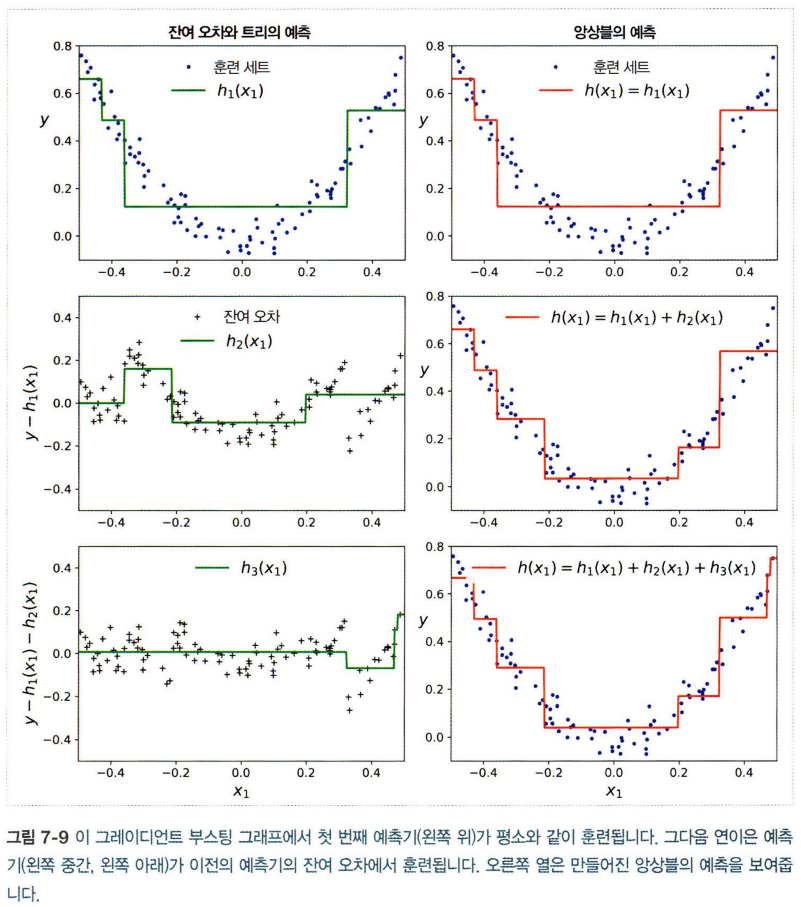

- 왼쪽 열은 위 세 트리의 예측, 오른쪽 열은 앙상블의 예측임.
- 첫 번째 행은 첫 번째 트리의 예측과 똑같음.(앙상블에 트리 하나만 있기 때문)
- 두 번째 행에서는 두 번째 트리가 첫 번쨰 트리의 잔여 오차에 대해 학습함. 오른쪽의 앙상블 예측이 두 개의 트리 예측의 합과 같음.
- 트리가 앙상블에 추가될수록 앙상블의 예측이 향상됨.

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
#learning_rate: 각 트리의 기여 정도 조절.
#0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 에측의 성능은 향상됨.

gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

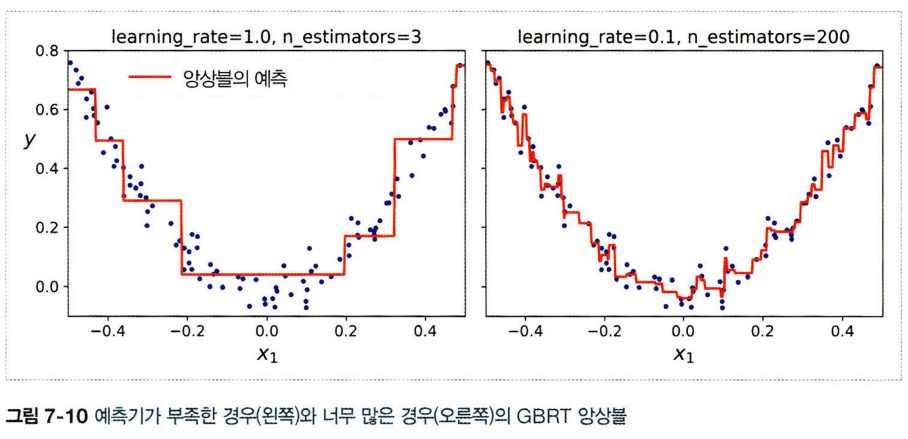

- 최적의 트리 수를 찾기 위해서 **조기 종료 기법**을 사용할 수 있음. 이를 간단하게 구현하기 위해 staged_predict() 메서드를 이용함.
-  staged_predict() 메서드는 훈련의 각 단계(트리 하나, 트리 두 개 등)에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환함.

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120)

In [21]:
#연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련 멈춤
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break  #조기 종료

- XGBoost

In [22]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [23]:
#xgb 자동 조기 종료
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.36803
[1]	validation_0-rmse:0.26821
[2]	validation_0-rmse:0.20613
[3]	validation_0-rmse:0.16711
[4]	validation_0-rmse:0.13419
[5]	validation_0-rmse:0.11171
[6]	validation_0-rmse:0.09741
[7]	validation_0-rmse:0.08930
[8]	validation_0-rmse:0.08548
[9]	validation_0-rmse:0.08331
[10]	validation_0-rmse:0.08209
[11]	validation_0-rmse:0.08140
[12]	validation_0-rmse:0.08103
[13]	validation_0-rmse:0.08076
[14]	validation_0-rmse:0.08059
[15]	validation_0-rmse:0.08127


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


###7.6 스태킹
- 앙상블에 속한 모든 예측기의 예측을 취합하는 모델을 훈련시켜 최종 예측을 함.